# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data 


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [222]:
import warnings
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [5]:
data.isna().any().any() #в данных пропуски есть

True

In [6]:
data = data.fillna('') #заполнение пустой строкой

In [7]:
data.head() #первые пять строк датафрейма с преобраованием пропусков

,id,keyword,location,text,target
0,1,,,Our Deeds are the Reason of this #earthquake M...,1
1,4,,,Forest fire near La Ronge Sask. Canada,1
2,5,,,All residents asked to 'shelter in place' are ...,1
3,6,,,"13,000 people receive #wildfires evacuation or...",1
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1


**Проверка на обучающей выборке**

In [8]:
train.isna().any().any() #пропуски присутствуют

True

In [9]:
train = train.fillna('') #заполнение пустой строкой

**Проверка на тестовой выборке**

In [10]:
test.isna().any().any() #пропуски присутствуют

True

In [11]:
test = test.fillna('') #заполнение пустой строкой

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [12]:
print(f'Число класса 0 в обучающей выборке: {train["target"].value_counts()[0]}')
print(f'Число класса 1 в обучающей выборке: {train["target"].value_counts()[1]}')

Число класса 0 в обучающей выборке: 3024
Число класса 1 в обучающей выборке: 2305


**Интерпретация**: мы наблюдаем явный перекос в сторону класса 0, класс 0 составляет 57% из совокупного числа объектов в обучающей выборке — с одной стороны, дизбаланс классов не очень сильный, но потенциально может сказаться во время обучения моделей.

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [13]:
popular_keywords = train['keyword'].value_counts()
popular_keywords

                         44
damage                   36
siren                    35
wreckage                 34
fatalities               33
                         ..
rescue                   16
epicentre                10
radiation%20emergency     7
inundation                7
threat                    6
Name: keyword, Length: 222, dtype: int64

**Способ 1: визуализация в matplotlib**

In [53]:
popular_keywords = train['keyword'].value_counts()[1:11].index.tolist()

In [54]:
train_target_0 = train[train['target'] == 0]
train_target_1 = train[train['target'] == 1]

In [55]:
#создам списки подсчета
train_target_0count = []
train_target_1count = []
for i in popular_keywords:
    train_target_0count.append(train_target_0[train_target_0.keyword == i].shape[0])
for i in popular_keywords:
    train_target_1count.append(train_target_1[train_target_1.keyword == i].shape[0])

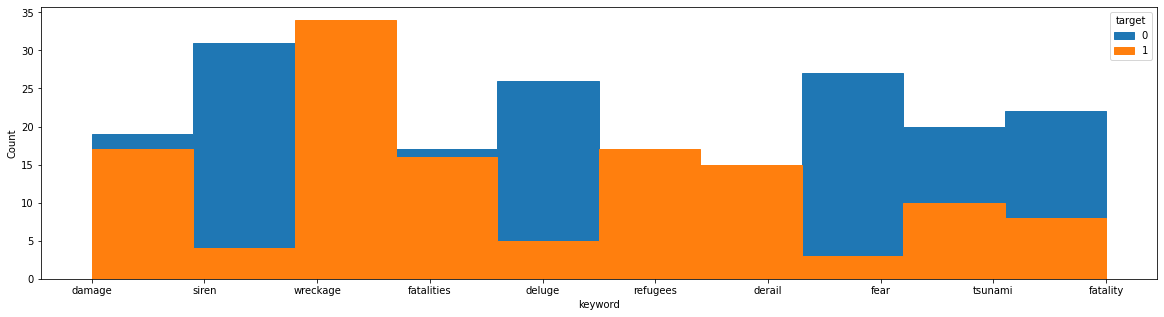

In [294]:
plt.figure(figsize = (20,5))
plt.hist(popular_keywords, weights = train_target_0count, histtype='step', stacked=True, fill = True, label = '0')
plt.hist(popular_keywords, weights = train_target_1count, histtype='step', stacked=True, fill = True, label = '1')
plt.xlabel('keyword')
plt.ylabel('Count')
plt.legend(title = "target")
plt.show()

**Способ 2: визуализация в seaborn**

In [57]:
train_pk = train.loc[train['keyword'].isin(popular_keywords)] #фильтрация датасета по popular_keywords

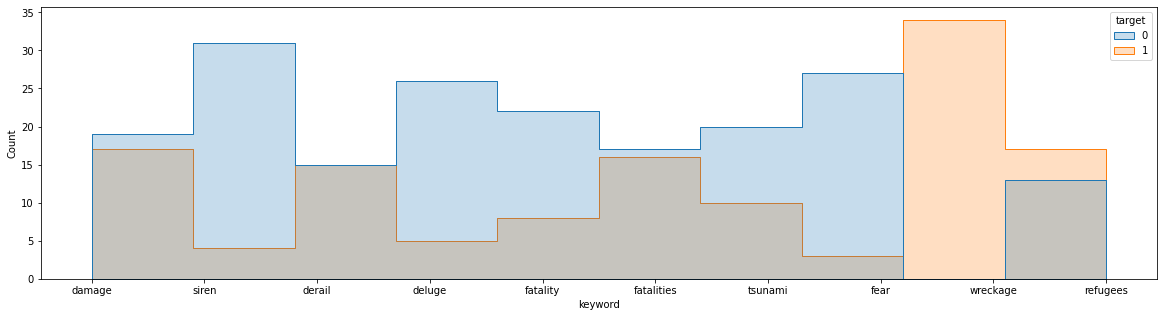

In [296]:
plt.figure(figsize = (20,5))
sns.histplot(data = train_pk, x = 'keyword', hue = 'target', element = 'step', multiple = 'layer', discrete = False)
plt.show() #по обучающей выборке

In [60]:
data_pk = data.loc[data['keyword'].isin(popular_keywords)] #фильтрация датасета по popular_keywords

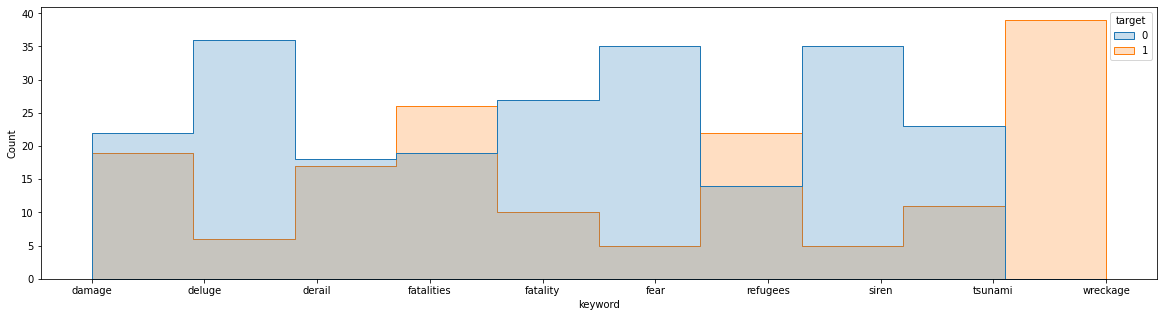

In [295]:
plt.figure(figsize = (20,5))
sns.histplot(data = data_pk, x = 'keyword', hue = 'target', element = 'step', multiple = 'layer', discrete = False)
plt.show() #по всей выборке

**Выводы**: мы видим, что реальным катастрофам в наиболее вероятной степени соответствовали слова, связанные с ущербами, смертями и разрушениями (см. ключевые слова damage, fatalities, wreckage). Также отдельным классом можно выделить беженцев. При этом, например, сообщения о сиренах и страхе (что, в отличие от ключевых слов в предыдущем предложении, является предвестником катастрофы, а не ее результатом), как правило, реальным катастрофам не соответствовали. Иными словами, твиты о катастрофах действительны, если как правило сообщают о результатах катастрофы.

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [62]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [63]:
t = train['keyword'] + " " + train['location'] + " " + train['text']
target = train['target']
train_new = pd.DataFrame(pd.concat([t, target],axis = 1))

In [64]:
train_new.columns = ['text', 'target']

In [65]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [66]:
import nltk

In [27]:
nltk.download("punkt", quiet=True)

True

In [297]:
from sklearn.feature_extraction.text import CountVectorizer

cnt_vec = CountVectorizer()
X = cnt_vec.fit_transform(train['text']) 
X #получилась матрица размера 5329x16937

<5329x16937 sparse matrix of type '<class 'numpy.int64'>'
	with 78185 stored elements in Compressed Sparse Row format>

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [113]:
from string import punctuation

In [298]:
def contains_digit(s: str) -> bool:
    return any(map(str.isdigit, s))

def contains_punctuation(s: str) -> bool:
    return any(p in s for p in punctuation)

def is_hashtag(s: str) -> bool:
    return s.startswith('#')

def is_mention(s: str) -> bool:
    return s.startswith('@')

def investigate_vocabulary(vocabulary):
    digcounter = 0
    punctcounter = 0
    hashcounter = 0
    mentionscounter = 0
    for key, items in vocabulary.items():
        if contains_digit(key):
            digcounter += 1
        if contains_punctuation(key):
            punctcounter += 1
        if is_hashtag(key):
            hashcounter += 1
        if is_mention(key):
            mentionscounter += 1
    print('With digit:      ', digcounter
          )
    print('With punctuation:', punctcounter
          )
    print('Hashtags:        ', hashcounter
          )
    print('Mentions:        ', mentionscounter
          )

In [115]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [ ]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [101]:
investigate_vocabulary(cnt_vec.vocabulary_) #слов с цифрами 3812, слов с пунктуацией 315, нет слов-упоминаний и слов-хэштегов

With digit:       3663
With punctuation: 300
Hashtags:         0
Mentions:         0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [299]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

In [303]:
cnt_vec_tweet = CountVectorizer(tokenizer = TweetTokenizer().tokenize)
X_tweet = cnt_vec_tweet.fit_transform(train['text'])

In [304]:
investigate_vocabulary(cnt_vec_tweet.vocabulary_)

With digit:       3781
With punctuation: 7136
Hashtags:         1440
Mentions:         1669


**Сравнение:** TweetTokenizer гораздо лучше работает с данными, нежели обычный токенайзер. TweetTokenizer, во-первых, токенизировал гораздо больше объектов, во-вторых, нашел важные для Твиттера и социальных сетей в целом токены - с хэштегами и упоминаниями. Обычный токенайзер в свою очередь хэштеги и упоминания не нашел, в целом токенизировал меньше объектов

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [305]:
from nltk.stem.snowball import SnowballStemmer

In [306]:
def contains_only_latin_letters(s: str) -> bool:
    if s.isalpha():
        if s.isascii():
            return True
        else:
            return False
    else:
        return False

def is_emoji(s: str) -> bool:
    if len(s) >= 2:
        if not any(map(str.isalpha, s)):
            if any(p in s for p in punctuation) and "(" in s:
                return True
            elif any(p in s for p in punctuation) and ")" in s:
                return True
            else:
                return False
        else:
            return False
    else:
        return False

def is_hashtag(s: str) -> bool:
    return s.startswith('#')

def custom_tokenizer(s: str) -> List[str]:    
    s = s.lower()
    tokenlist = TweetTokenizer().tokenize(s)
    newlist = []
    for token in tokenlist:
        if (contains_only_latin_letters(token) or is_emoji(token) or is_hashtag(token)) and (token not in nltk.corpus.stopwords.words('english')):
            newlist.append(token)
    stemmer = SnowballStemmer("english")
    finlist = []
    for obj in newlist:
        finlist.append(stemmer.stem(obj))
    return finlist

In [307]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [308]:
for text in train['text'][:10]:
    print(custom_tokenizer(text))

['ash', 'australia', 'collaps', 'trent', 'bridg', 'among', 'worst', 'histori', 'england', 'bundl', 'australia']
['great', 'michigan', 'techniqu', 'camp', 'thank', '#goblu', '#wrestleon']
['cnn', 'tennesse', 'movi', 'theater', 'shoot', 'suspect', 'kill', 'polic']
['still', 'riot', 'coupl', 'hour', 'left', 'class']
['crack', 'path', 'wipe', 'morn', 'beach', 'run', 'surfac', 'wound', 'left', 'elbow', 'right', 'knee']
['expert', 'franc', 'begin', 'examin', 'airplan', 'debri', 'found', 'reunion', 'island', 'french', 'air', 'accid', 'expert', '#mlb']
['came', 'kill', 'indian', 'fun', 'video', 'smirk', 'remorseless', 'pakistani', 'killer', 'show', 'boast']
['except', 'idk', 'realli', 'burn']
['destroy', 'hous']
['polic', 'offic', 'wound', 'suspect', 'dead', 'exchang', 'shot']


## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [309]:
vectorizer = CountVectorizer(tokenizer = custom_tokenizer)
bow = vectorizer.fit_transform(train['text'])
bow_test = vectorizer.transform(test['text'])

2. Обучите LogisticRegression на полученных признаках.


In [310]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=42)

In [311]:
clf.fit(bow, train['target'])

LogisticRegression(random_state=42)

In [312]:
pred = clf.predict(bow_test)

3. Посчитайте метрику f1-score на тестовых данных.

In [313]:
from sklearn.metrics import f1_score

print(f'F1 score: {f1_score(test["target"], pred):.4f}')

F1 score: 0.7501


## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [314]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(tokenizer = custom_tokenizer)
tfidf_train = tfidf_vec.fit_transform(train['text'])
tfidf_test = tfidf_vec.transform(test['text'])

In [315]:
clf_tfidf = LogisticRegression(random_state=42)

In [316]:
clf_tfidf.fit(tfidf_train, train['target'])

LogisticRegression(random_state=42)

In [317]:
pred_tfidf = clf_tfidf.predict(tfidf_test)

In [318]:
print(f'F1 score: {f1_score(test["target"], pred_tfidf):.4f}')

F1 score: 0.7437


1. **Ответ:** Качество незначительно ухудшилось, но лишь на 0.0064. Фактически можно говорить про отсутствие изменения качества

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [204]:
tfidf_vec_new = TfidfVectorizer(tokenizer = custom_tokenizer, max_df=0.9)
tfidf_train_new = tfidf_vec_new.fit_transform(train['text'])
tfidf_test_new = tfidf_vec_new.transform(test['text'])

In [207]:
tfidf_train

<5329x9382 sparse matrix of type '<class 'numpy.float64'>'
	with 43671 stored elements in Compressed Sparse Row format>

In [209]:
tfidf_train_new #размер матрицы не поменялся

<5329x9382 sparse matrix of type '<class 'numpy.float64'>'
	with 43671 stored elements in Compressed Sparse Row format>

In [210]:
clf_tfidf_new = LogisticRegression(random_state=42)

In [211]:
clf_tfidf_new.fit(tfidf_train_new, train['target'])

LogisticRegression(random_state=42)

In [212]:
pred_tfidf_new = clf_tfidf_new.predict(tfidf_test_new)

In [214]:
print(f'F1 score: {f1_score(test["target"], pred_tfidf_new):.4f}')

F1 score: 0.7437


2. **Ответ:** Размер матрицы не изменился, качество не изменилось

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [215]:
tfidf_vec_new2 = TfidfVectorizer(tokenizer = custom_tokenizer, max_df=0.9, min_df = 0.01)
tfidf_train_new2 = tfidf_vec_new2.fit_transform(train['text'])
tfidf_test_new2 = tfidf_vec_new2.transform(test['text'])

In [216]:
clf_tfidf_new2 = LogisticRegression(random_state=42)

In [217]:
clf_tfidf_new2.fit(tfidf_train_new2, train['target'])

LogisticRegression(random_state=42)

In [218]:
pred_tfidf_new2 = clf_tfidf_new2.predict(tfidf_test_new2)

In [220]:
print(f'F1 score: {f1_score(test["target"], pred_tfidf_new2):.4f}')

F1 score: 0.6267


3. **Ответ:** Нет, не удалось добиться улучшения качества. Наоборот, качество заметно снизилось.

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [223]:
from sklearn.feature_extraction.text import HashingVectorizer

hashvectorizer = HashingVectorizer(tokenizer = custom_tokenizer, n_features=5000)
hashbow = hashvectorizer.fit_transform(train['text'])
hashbow_test = hashvectorizer.transform(test['text'])

In [224]:
hashclf = LogisticRegression(random_state=42)

In [225]:
hashclf.fit(hashbow, train['target'])

LogisticRegression(random_state=42)

In [226]:
hashpred = hashclf.predict(hashbow_test)

In [228]:
print(f'F1 score: {f1_score(test["target"], hashpred):.3f}')

F1 score: 0.724


2. Какой из подходов показал самый высокий результат?

2. **Ответ:** Самый высокий результат в итоге показал вариант с CountVectorizer и f-1 score по нему составил 0.7501. То есть самый первый вариант оказался наиболее эффективным с точки зрения значения f-1 меры.

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

**Примечание**: Изначальная f1 мера была равна 0.7501. По-хорошему это задание, видимо, можно было и не делать, но я предложил три альтернативных варианта улучшения значения меры. Все способы предполагают манипуляции с гиперпараметрами.

**СПОСОБ 1**

In [288]:
clf = LogisticRegression(random_state=42, max_iter = 300, solver = 'saga')
clf.fit(bow, train['target'])
pred = clf.predict(bow_test)
print(f'F1 score: {f1_score(test["target"], pred):.4f}')

F1 score: 0.7542


**СПОСОБ 2**

In [291]:
clf = LogisticRegression(random_state=42, max_iter = 300, penalty = 'l1', solver = 'saga')
clf.fit(bow, train['target'])
pred = clf.predict(bow_test)
print(f'F1 score: {f1_score(test["target"], pred):.4f}')

F1 score: 0.7540


**СПОСОБ 3**

In [292]:
clf = LogisticRegression(random_state=42, max_iter = 300, penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5)
clf.fit(bow, train['target'])
pred = clf.predict(bow_test)
print(f'F1 score: {f1_score(test["target"], pred):.4f}')

F1 score: 0.7518
